In [5]:
# Setup
from evo.core import metrics
from evo.core.units import Unit
from evo.tools import log
log.configure_logging(verbose=True, debug=True, silent=False)

import pprint
import numpy as np

from evo.tools import plot
import matplotlib.pyplot as plt
from evo.tools.plot import PlotMode
from evo.core.metrics import PoseRelation
# temporarily override some package settings
from evo.tools.settings import SETTINGS

# temporarily override some package settings
SETTINGS.plot_figsize = [6, 6]
SETTINGS.plot_split = True
SETTINGS.plot_usetex = False

# magic plot configuration
%matplotlib inline
%load_ext ipywidgets

[DEBUG][2024-11-04 19:05:02,915][log.configure_logging():113]
System info:
Python 3.8.20
Linux-5.4.0-150-generic-x86_64-with-glibc2.17
kid@kid-seg

The ipywidgets extension is already loaded. To reload it, use:
  %reload_ext ipywidgets


In [6]:
# interactive widgets configuration
import ipywidgets

check_opts_ape = {"align": False, "correct_scale": False, "show_plot": True}
check_boxes_ape=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_ape.items()]
check_opts_rpe = {"align": False, "correct_scale": False, "all_pairs": False, "show_plot": True}
check_boxes_rpe=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_rpe.items()]
delta_input = ipywidgets.FloatText(value=1.0, description='delta', disabled=False, color='black')
delta_unit_selector=ipywidgets.Dropdown(
    options={u.value: u for u in Unit if u is not Unit.seconds},
    value=Unit.frames, description='delta_unit'
)
plotmode_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PlotMode},
    value=PlotMode.xy, description='plot_mode'
)
pose_relation_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PoseRelation},
    value=PoseRelation.translation_part, description='pose_relation'
)

In [7]:
from evo.tools import file_interface
from evo.core import sync
from rosbags.rosbag1 import Reader as Rosbag1Reader
with Rosbag1Reader("aloam.bag") as reader1, Rosbag1Reader("scaloam.bag") as reader2:
    traj_ref = file_interface.read_bag_trajectory(reader1, "/aft_mapped_to_init")
    traj_est = file_interface.read_bag_trajectory(reader2, "/aft_mapped_to_init")
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est)

[DEBUG][2024-11-04 19:05:05,603][file_interface.read_bag_trajectory():328]
Loaded 392 nav_msgs/msg/Odometry messages of topic: /aft_mapped_to_init
[DEBUG][2024-11-04 19:05:05,900][file_interface.read_bag_trajectory():328]
Loaded 1331 nav_msgs/msg/Odometry messages of topic: /aft_mapped_to_init
[DEBUG][2024-11-04 19:05:05,971][sync.associate_trajectories():110]
Found 391 of max. 392 possible matching timestamps between...
	first trajectory
and:	second trajectory
..with max. time diff.: 0.01 (s) and time offset: 0.0 (s).


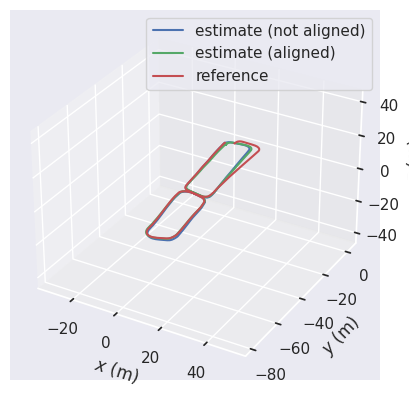

In [9]:
fig = plt.figure()
traj_by_label = {
    "estimate (not aligned)": traj_est,
    "estimate (aligned)": traj_est_aligned,
    "reference": traj_ref
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)
plt.savefig('slam.png')
plt.show()

In [10]:
#APE
import evo.main_ape as main_ape
import evo.common_ape_rpe as common

count = 0
results = []

def callback_ape(pose_relation, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)
    
    result = main_ape.ape(traj_ref, traj_est, est_name=est_name,
                          pose_relation=pose_relation, align=align, correct_scale=correct_scale)
    count += 1
    results.append(result)
    
    if show_plot:
        fig = plt.figure()
        ax = plot.prepare_axis(fig, plot_mode)
        plot.traj(ax, plot_mode, traj_ref, style="--", alpha=0.5)
        plot.traj_colormap(
            ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
            min_map=result.stats["min"], max_map=result.stats["max"])
        plt.savefig('slam_ape.png')
    
_ = ipywidgets.interact_manual(callback_ape, pose_relation=pose_relation_selector, plot_mode=plotmode_selector,
                               **{c.description: c.value for c in check_boxes_ape})

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

In [11]:
# PRE
import evo.main_rpe as main_rpe

count = 0
results = []

def callback_rpe(pose_relation, delta, delta_unit, all_pairs, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="RPE Test #{}".format(count)
    result = main_rpe.rpe(traj_ref, traj_est, est_name=est_name,
                          pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, 
                          all_pairs=all_pairs, align=align, correct_scale=correct_scale, 
                          support_loop=True)
    count += 1
    results.append(result)
    
    if show_plot:
        fig = plt.figure()
        ax = plot.prepare_axis(fig, plot_mode)
        plot.traj(ax, plot_mode, traj_ref, style="--", alpha=0.5)
        plot.traj_colormap(
            ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
            min_map=result.stats["min"], max_map=result.stats["max"])
        plt.savefig('slam_pre.png')

_ = ipywidgets.interact_manual(callback_rpe, pose_relation=pose_relation_selector, plot_mode=plotmode_selector, 
                               delta=delta_input, delta_unit=delta_unit_selector, 
                               **{c.description: c.value for c in check_boxes_rpe})

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

In [15]:
import pandas as pd
from evo.tools import pandas_bridge

df = pd.DataFrame()
for result in results:
    df = pd.concat((df, pandas_bridge.result_to_df(result)), axis="columns")
df.to_csv('evo1.csv', index=False)
df

RPE Test #0
info      title                 RPE w.r.t. translation part (m)\nfor delta = 1...
          ref_name                                                      reference
          est_name                                                    RPE Test #0
          label                                                           RPE (m)
stats     rmse                                                           0.021097
          mean                                                           0.013873
          median                                                         0.008257
          std                                                            0.015895
          min                                                            0.000632
          max                                                            0.141887
          sse                                                            0.173583
np_arrays error_array           [0.0025790184346432712, 0.0031788781154649583,...
          seconds_from_start    [0.09995555877685547, 0.19990324974060059, 0.2...
          timestamps            [1730221954.9855864, 1730221955.085534, 173022...
          distances_from_start  [0.0014312485858197297, 0.0022153362972819578,...
          distances             [0.0024873940100553003, 0.006352657754789345, ...

In [13]:
df.loc["stats"]

,RPE Test #0
rmse,0.021097
mean,0.013873
median,0.008257
std,0.015895
min,0.000632
max,0.141887
sse,0.173583
